# Data Science in Economics and Business - Class Project
In this class project, you are supposed to work with GDP data taken from the International Monetary Fund.

**IMPORTANT:** <br>
Please enter the matriculation number of all group members here:
1. XXXXXX
2. YYYYYY
3. ZZZZZZ


In this class project, you will use the different techniques taught in the course: data handling, data visualization, and machine learning.

First load the necessary packages. <br>
If you want to use additional libraries you can add them to the following cell:

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import world_bank_data as wb
import wbgapi as wba
import datetime
sns.set()
import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import logging
import country_converter as coco

pd.set_option('display.max_rows', None)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Problem 1 - Data Handling
The basis of your work will be the following GDP dataset:

In [63]:
gdp = pd.read_csv("GDP_IMF.csv", sep=";")
gdp.sample(20)

,Country,year,GDP
3100,Peru,2005,74.232
3764,Montenegro,2008,4.564
3560,Puerto Rico,2007,89.524
6317,"South Sudan, Republic of",2019,4.044
2048,Middle East and Central Asia,2000,1258.49
285,Ethiopia,1993,9.143
4914,Niger,2013,10.206
4979,Vietnam,2013,212.728
7892,Puerto Rico,2026,125.124
6142,Western Hemisphere (Region),2018,27679.721


#### a)
As you can see, there are many missing values in the data. <br>
Before you can continue, you need to handle them. Proceed as follows:
- Delete those countries with no data at all (if any)
- Either delete the missing years for each country or use the years close by to approximate the missing value <br> *Example: Year 2004 is missing, but 2003 and 2005 are available; use the mean of GDP in 2003 and 2005 to replace missing year 2004.*

In [64]:
gdp = gdp.drop(gdp[gdp['year']>2022].index)

In [65]:
len(gdp['year'].unique())

31

In [66]:
no_data_counts_country = gdp.groupby('Country')['GDP'].apply(lambda x: (x=='no data').sum())
no_data_counts_country[no_data_counts_country > 0]

Country
Afghanistan                   12
Andorra                        8
Aruba                          3
Bosnia and Herzegovina         4
Czech Republic                 3
Estonia                        1
Georgia                        2
Iraq                           6
Kosovo                         8
Lebanon                        2
Liberia                        8
Lithuania                      3
Macao SAR                      9
Marshall Islands               5
Micronesia, Fed. States of     3
Montenegro                     8
Myanmar                        6
Nauru                         12
Palau                          8
San Marino                     8
Serbia                         5
Slovak Republic                1
Somalia                       19
South Sudan, Republic of      19
Syria                         12
Timor-Leste                    8
Tuvalu                         8
West Bank and Gaza             2
Name: GDP, dtype: int64

In [67]:
gdp = gdp.drop(gdp[gdp['Country'].isin(no_data_counts_country[no_data_counts_country >= 8].index)].index)

In [68]:
len(gdp['Country'].unique())

214

In [69]:
no_data_counts_year = gdp.groupby('year')['GDP'].apply(lambda x: (x=='no data').sum())
no_data_counts_year[no_data_counts_year > 0]

year
1992    13
1993    11
1994     9
1995     5
1996     4
1997     2
2021     1
2022     1
Name: GDP, dtype: int64

In [70]:
# Replace 'no data' with nan values and convert to float
gdp['GDP'] = gdp['GDP'].replace('no data', np.nan).astype(float)

# Set multi-index and sort
gdp.set_index(['Country', 'year'], inplace=True)
gdp.sort_index(inplace=True)

# Generate a full index of all year combinations for each country
all_years = range(gdp.index.get_level_values('year').min(), gdp.index.get_level_values('year').max() + 1)
full_index = pd.MultiIndex.from_product([gdp.index.get_level_values('Country').unique(), all_years], 
                                        names=['Country', 'year'])

# Reindex and interpolate
gdp = gdp.reindex(full_index)
gdp['GDP'] = gdp.groupby('Country', group_keys=False)['GDP'].apply(lambda group: group.interpolate(method='linear', limit_direction='both'))

# Reset the index
gdp.reset_index(inplace=True)


#### b)
We are only interested in the data on a country level and for years already passed. <br>
The dataset, however, also contains information on whole regions such as the EU or G7. <br>
It also contains predictions for GDP in the upcoming years. <br>
Delete these observations from the data. <br>
*Hint: Get a list of all unique values of the Country column.*

In [71]:
gdp['Country'].unique()

array(['ASEAN-5', 'Advanced economies', 'Africa (Region)', 'Albania',
       'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Aruba', 'Asia and Pacific', 'Australia',
       'Australia and New Zealand', 'Austria', 'Azerbaijan',
       'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean',
       'Central African Republic', 'Central America',
       'Central Asia and the Caucasus', 'Chad', 'Chile',
       "China, People's Republic of", 'Colombia', 'Comoros',
       'Congo, Dem. Rep. of the', 'Congo, Republic of ', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia',
       'Eastern Europe ', 'Ecuador', 'Egypt

In [72]:
country_mapping = {
    'Congo, Dem. Rep. of the': 'Democratic Republic of Congo',
    'Congo, Republic of ': 'Republic of Congo',
    'Taiwan Province of China': 'Taiwan SAR',
    'Lao P.D.R.': 'Lao People\'s Democratic Republic'
}

gdp['Country'] = gdp['Country'].replace(country_mapping)


In [73]:
gdp['Country'] = gdp['Country'].str.split(',').str[0]

In [74]:
gdp['Country'].unique()

array(['ASEAN-5', 'Advanced economies', 'Africa (Region)', 'Albania',
       'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Aruba', 'Asia and Pacific', 'Australia',
       'Australia and New Zealand', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Caribbean', 'Central African Republic',
       'Central America', 'Central Asia and the Caucasus', 'Chad',
       'Chile', 'China', 'Colombia', 'Comoros',
       'Democratic Republic of Congo', 'Republic of Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia',
       'Eastern Europe ', 'Ecuador', 'Egypt', 'El Salvador',
       'Emerg

In [75]:
import requests
from bs4 import BeautifulSoup

# Send a GET request
response = requests.get('https://www.imf.org/en/Countries')

# Parse the response content with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the country names
countries = [country.text for country in soup.select('a[href^="/en/Countries/"]')]

In [76]:
countries = countries[11:]

In [77]:
countries = [c.replace('Congo, Democratic Republic of the', 'Democratic Republic of Congo') for c in countries]
countries = [c.replace('Congo, Republic of', 'Republic of Congo') for c in countries]
countries = [c.replace('Syrian Arab Republic', 'Syria') for c in countries]
countries = [c.replace('Hong Kong Special Administrative Region', 'Hong Kong SAR') for c in countries]
countries = [c.replace('Macao Special Administrative Region', 'Macao SAR') for c in countries]

countries = [c.replace('North Macedonia', 'North Macedonia ') for c in countries]
countries = [c.replace('Türkiye', 'Tuerkiye') for c in countries]
countries = [c.replace('Côte d\'Ivoire', 'Cote d\'Ivoire') for c in countries]
countries.append('Taiwan SAR')
countries.append('Puerto Rico')
countries.append('Saint Kitts and Nevis')
countries.append('Saint Lucia')
countries.append('Saint Vincent and the Grenadines')
countries.append('Sao Tome und Principe')
countries.append('West Bank and Gaza')


In [78]:
countries = [country.split(',')[0] for country in countries]
len(countries)

205

In [79]:
len(gdp['Country'].unique())

214

In [80]:
missing_countries = gdp[~gdp['Country'].isin(countries)]

for country in missing_countries['Country'].unique():
    print(country)

ASEAN-5
Advanced economies
Africa (Region)
Asia and Pacific
Australia and New Zealand
Caribbean
Central America
Central Asia and the Caucasus
East Asia
Eastern Europe 
Emerging and Developing Asia
Emerging and Developing Europe
Emerging market and developing economies
Euro area
Europe
European Union
Latin America and the Caribbean
Major advanced economies (G7)
Middle East (Region)
Middle East and Central Asia
North Africa
North America
Other advanced economies
Pacific Islands 
South America
South Asia
Southeast Asia
Sub-Saharan Africa
Sub-Saharan Africa (Region) 
Western Europe
Western Hemisphere (Region)
World


In [81]:
gdp = gdp[gdp['Country'].isin(countries)]

In [82]:
len(gdp['Country'].unique())

182

In [83]:
gdp['year'].unique()

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [84]:
gdp.head()

,Country,year,GDP
93,Albania,1992,0.843
94,Albania,1993,1.461
95,Albania,1994,2.361
96,Albania,1995,2.882
97,Albania,1996,3.200


# Problem 2 - Data Visualization
#### a)
To get some first insights in the data, create meaningful plots. <br>
You can use any kind that you deem useful: histograms, line plots, etc.

In [85]:
# Use plotly express to create an interactive scatter plot
fig = px.scatter(gdp, x=gdp['year'], y=gdp['GDP'], color='Country', hover_name='Country')

fig.update_layout(
    xaxis_title=f'Year',
    yaxis_title=f'GDP',
    title='Countries GDP in Billions [USD] (1992-2023)',
    showlegend=True
)

# Show the interactive plot
fig.show()

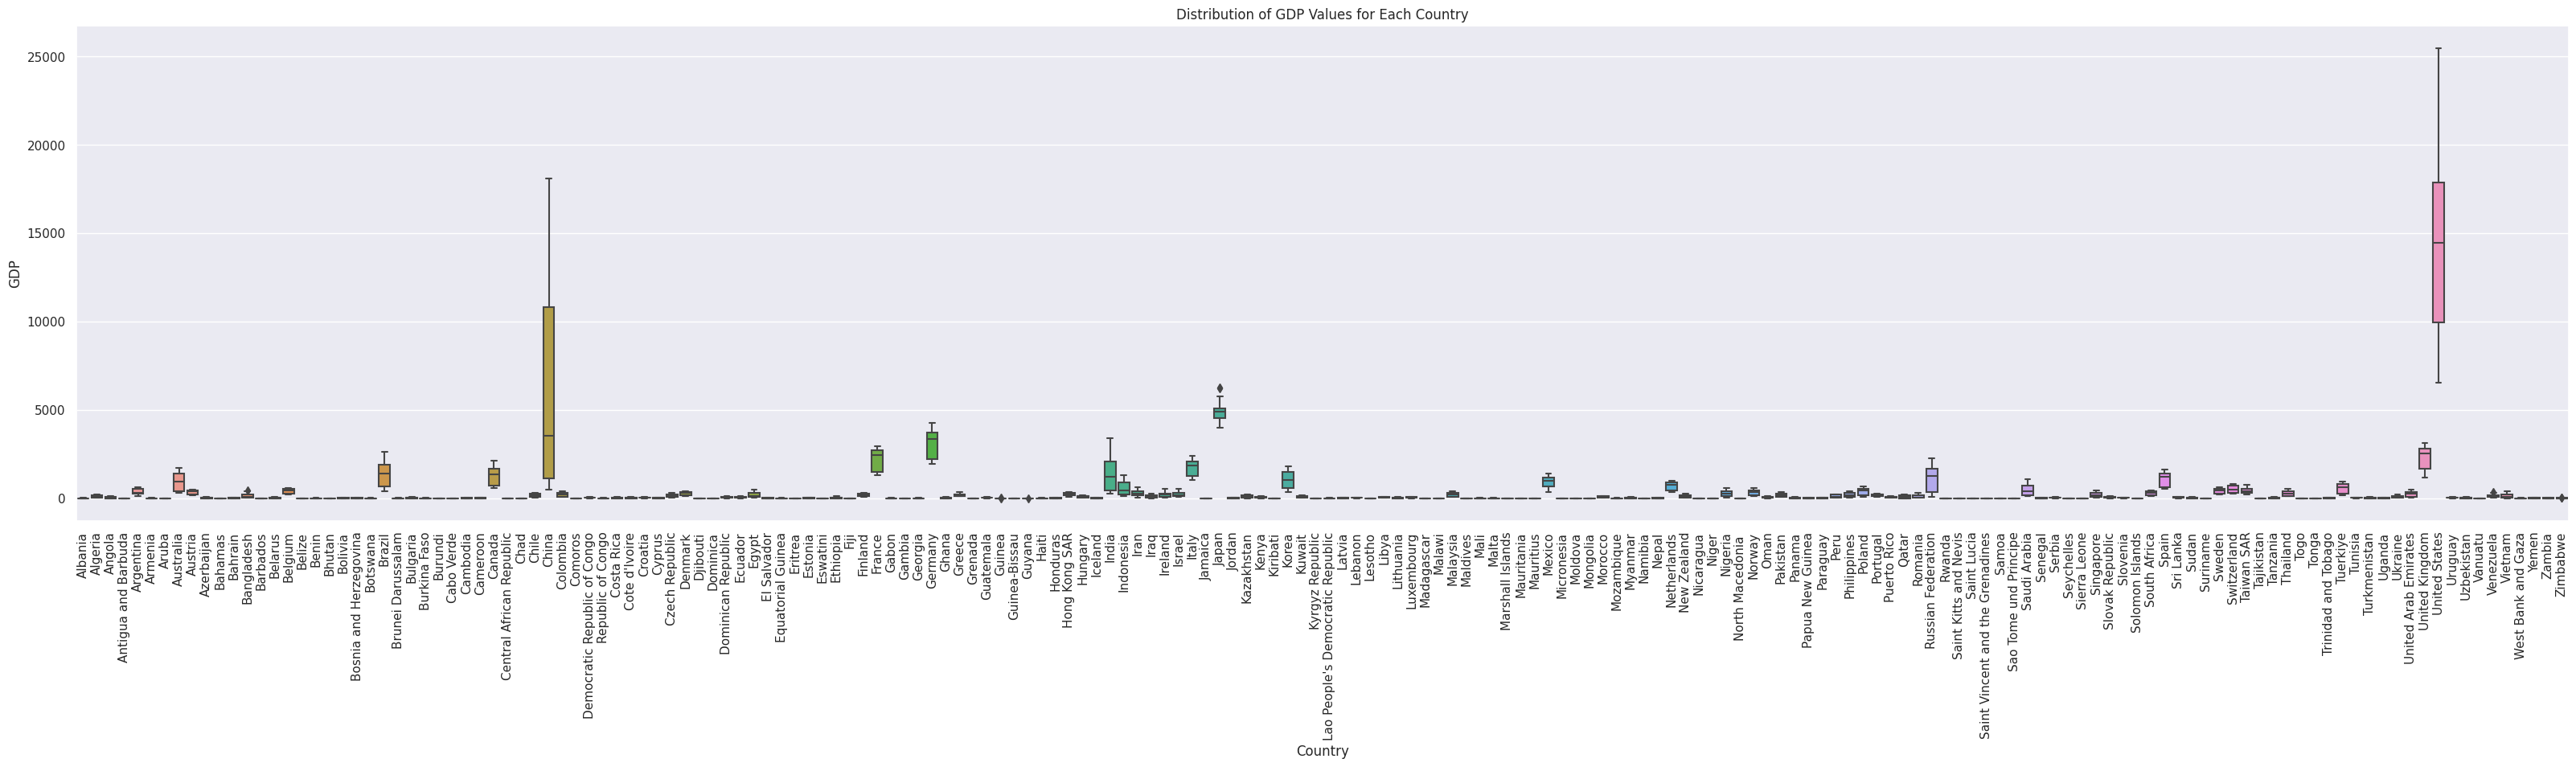

In [86]:
import seaborn as sns

plt.figure(figsize=(40, 8))
sns.boxplot(x='Country', y='GDP', data=gdp)
plt.title('Distribution of GDP Values for Each Country')
plt.xticks(rotation=90) # This makes the country names vertical so they don't overlap
plt.show()

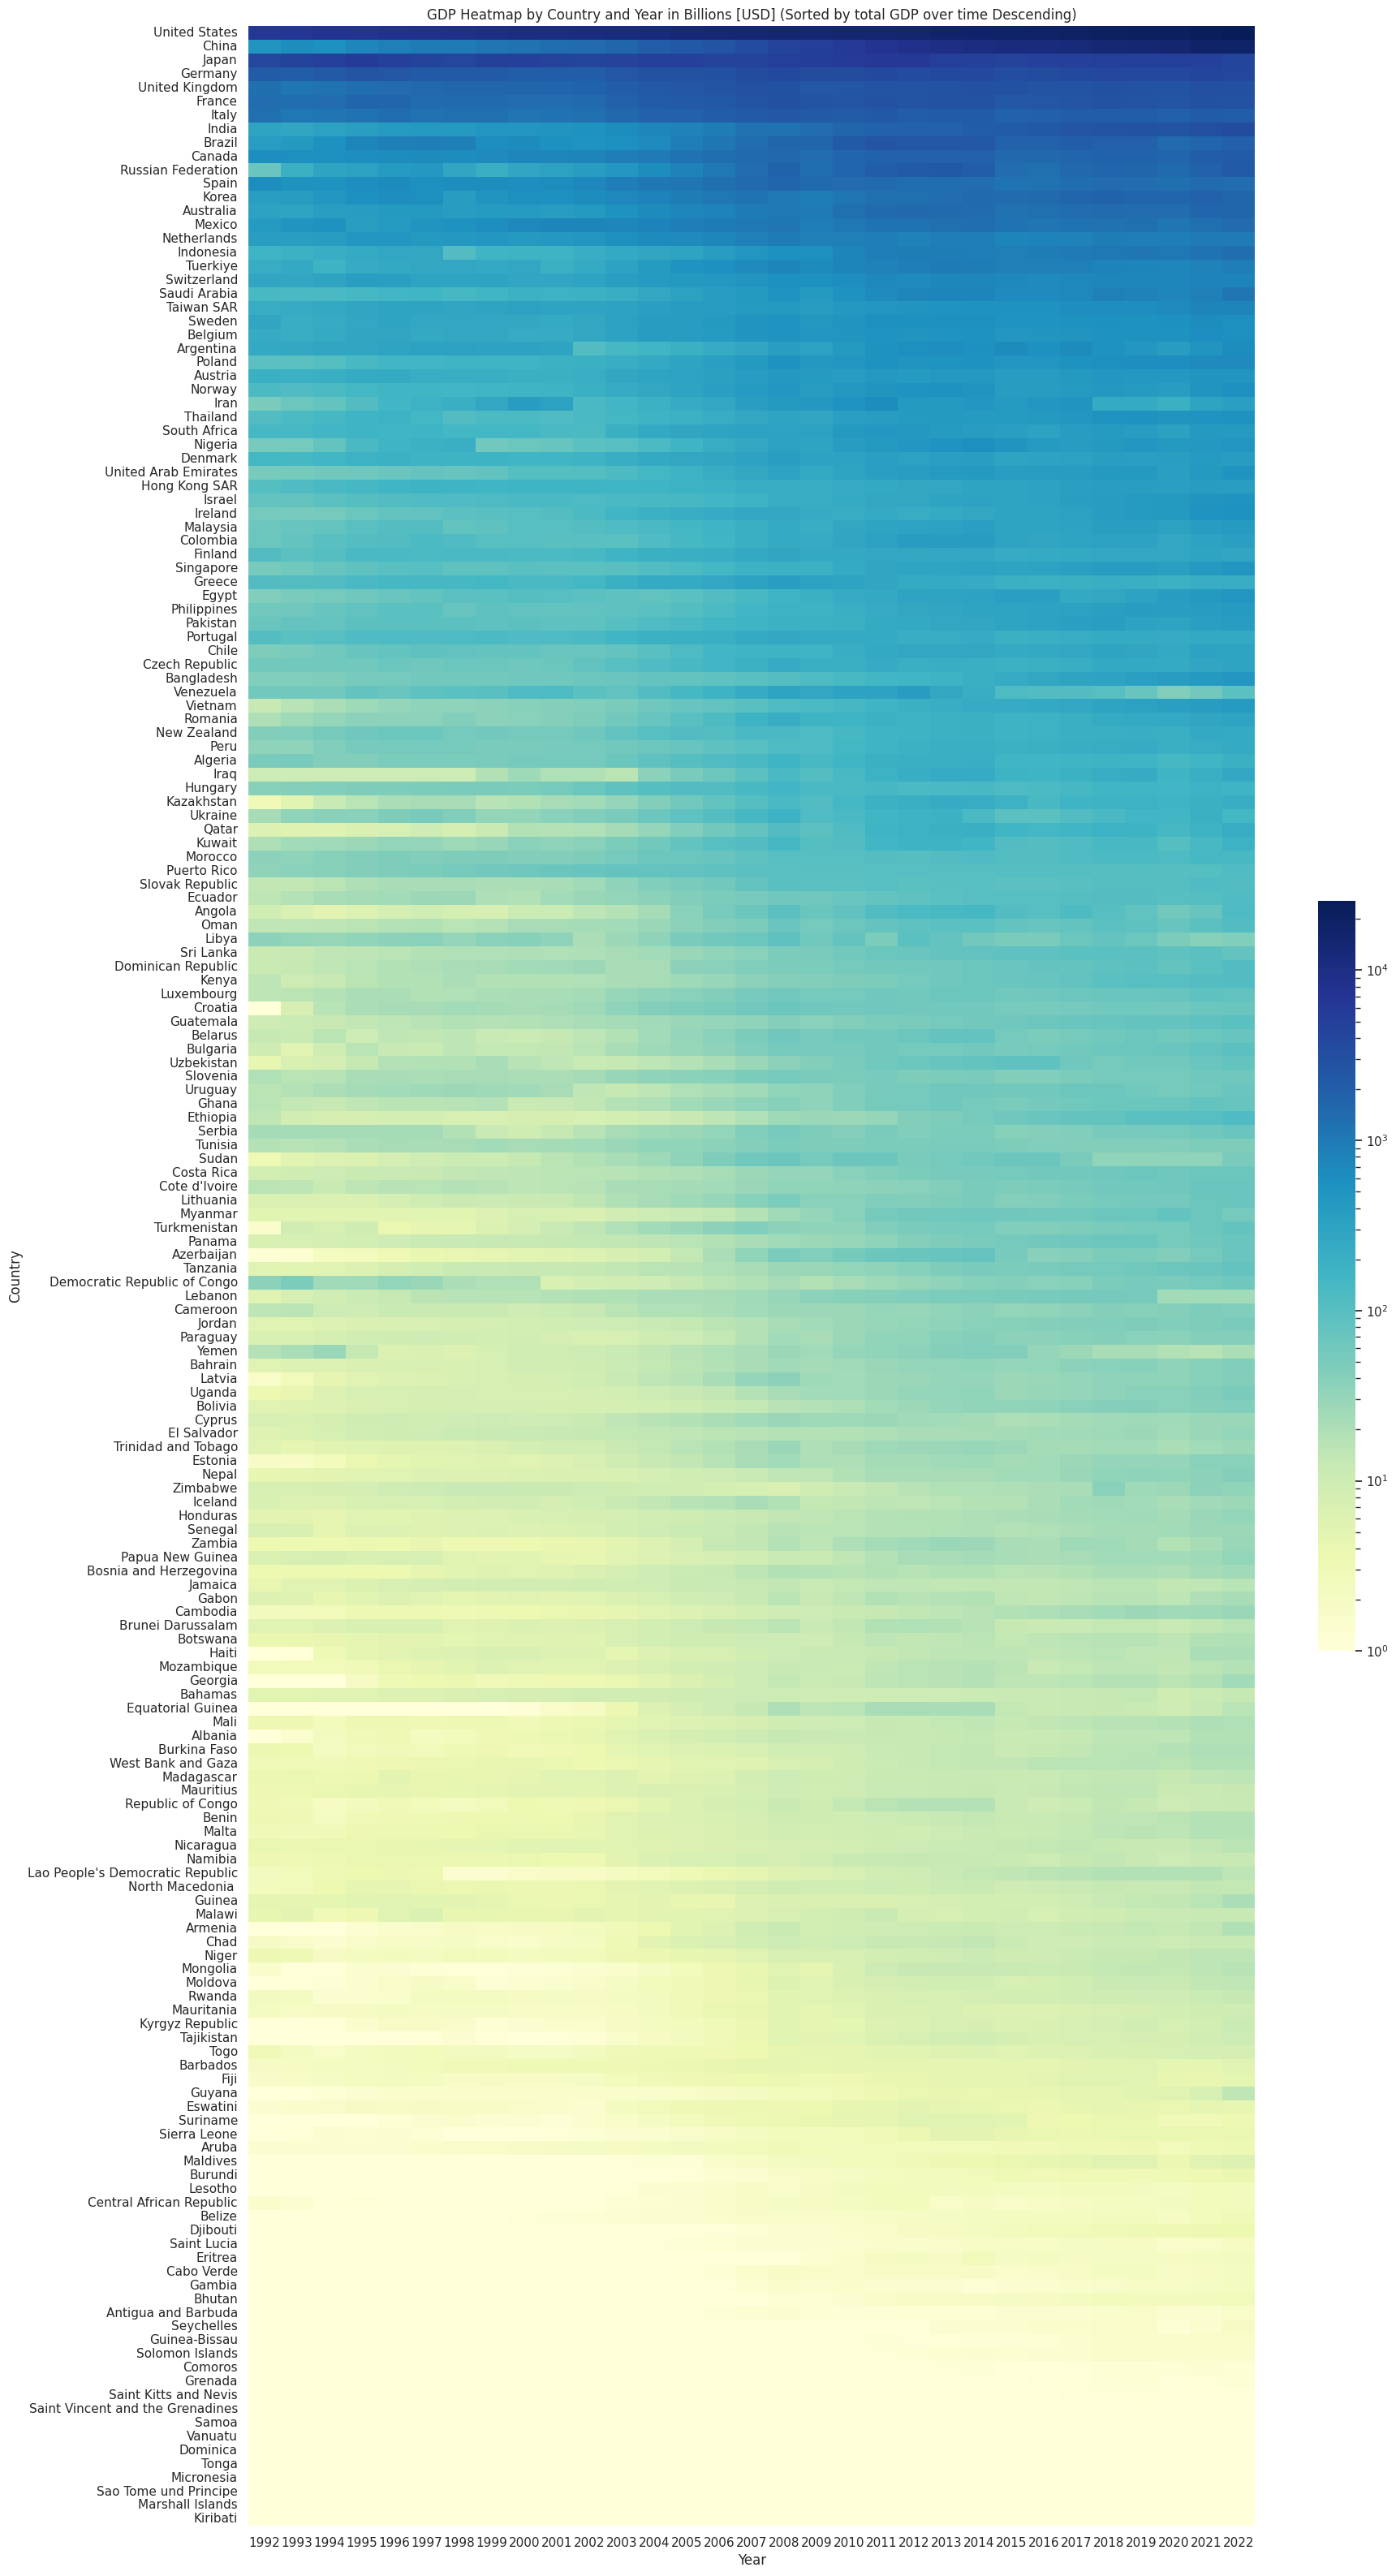

In [87]:
import matplotlib.colors as clrs


def heatmap_normal_scaling_ordered_alphabetical():
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

    plt.figure(figsize=(20, 40))  # Adjust the figure size as needed
    sns.heatmap(pivot_data, cmap='YlGnBu', cbar_kws={"shrink": 0.3})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year')

    plt.show()

def heatmap_log_scaling_ordered_alphabetical():
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP').fillna(0)

    # Create a heatmap with log scaling for the legend
    plt.figure(figsize=(20, 40))
    sns.heatmap(pivot_data, cmap='YlGnBu', norm=clrs.LogNorm(vmin=1, vmax=pivot_data.values.max()), cbar_kws={"shrink": 0.3})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year (Log Scaling)')


def heatmap_log_scaling_ordered_gdp(): 
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP').fillna(0)

    # Calculate the total GDP for each country and sort by GDP in descending order
    total_gdp = pivot_data.sum(axis=1)
    sorted_countries = total_gdp.sort_values(ascending=False).index

    # Reorder the rows in the pivot_data DataFrame based on the sorted countries
    pivot_data_sorted = pivot_data.loc[sorted_countries]

    # Create a heatmap with log scaling for the legend
    plt.figure(figsize=(20, 40))
    sns.heatmap(pivot_data_sorted, cmap='YlGnBu', norm=clrs.LogNorm(vmin=1, vmax=pivot_data.values.max()), cbar_kws={"shrink": 0.3})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year in Billions [USD] (Sorted by total GDP over time Descending)')
    plt.show()


#heatmap_normal_scaling_ordered_alphabetical()
#heatmap_log_scaling_ordered_alphabetical()
heatmap_log_scaling_ordered_gdp()

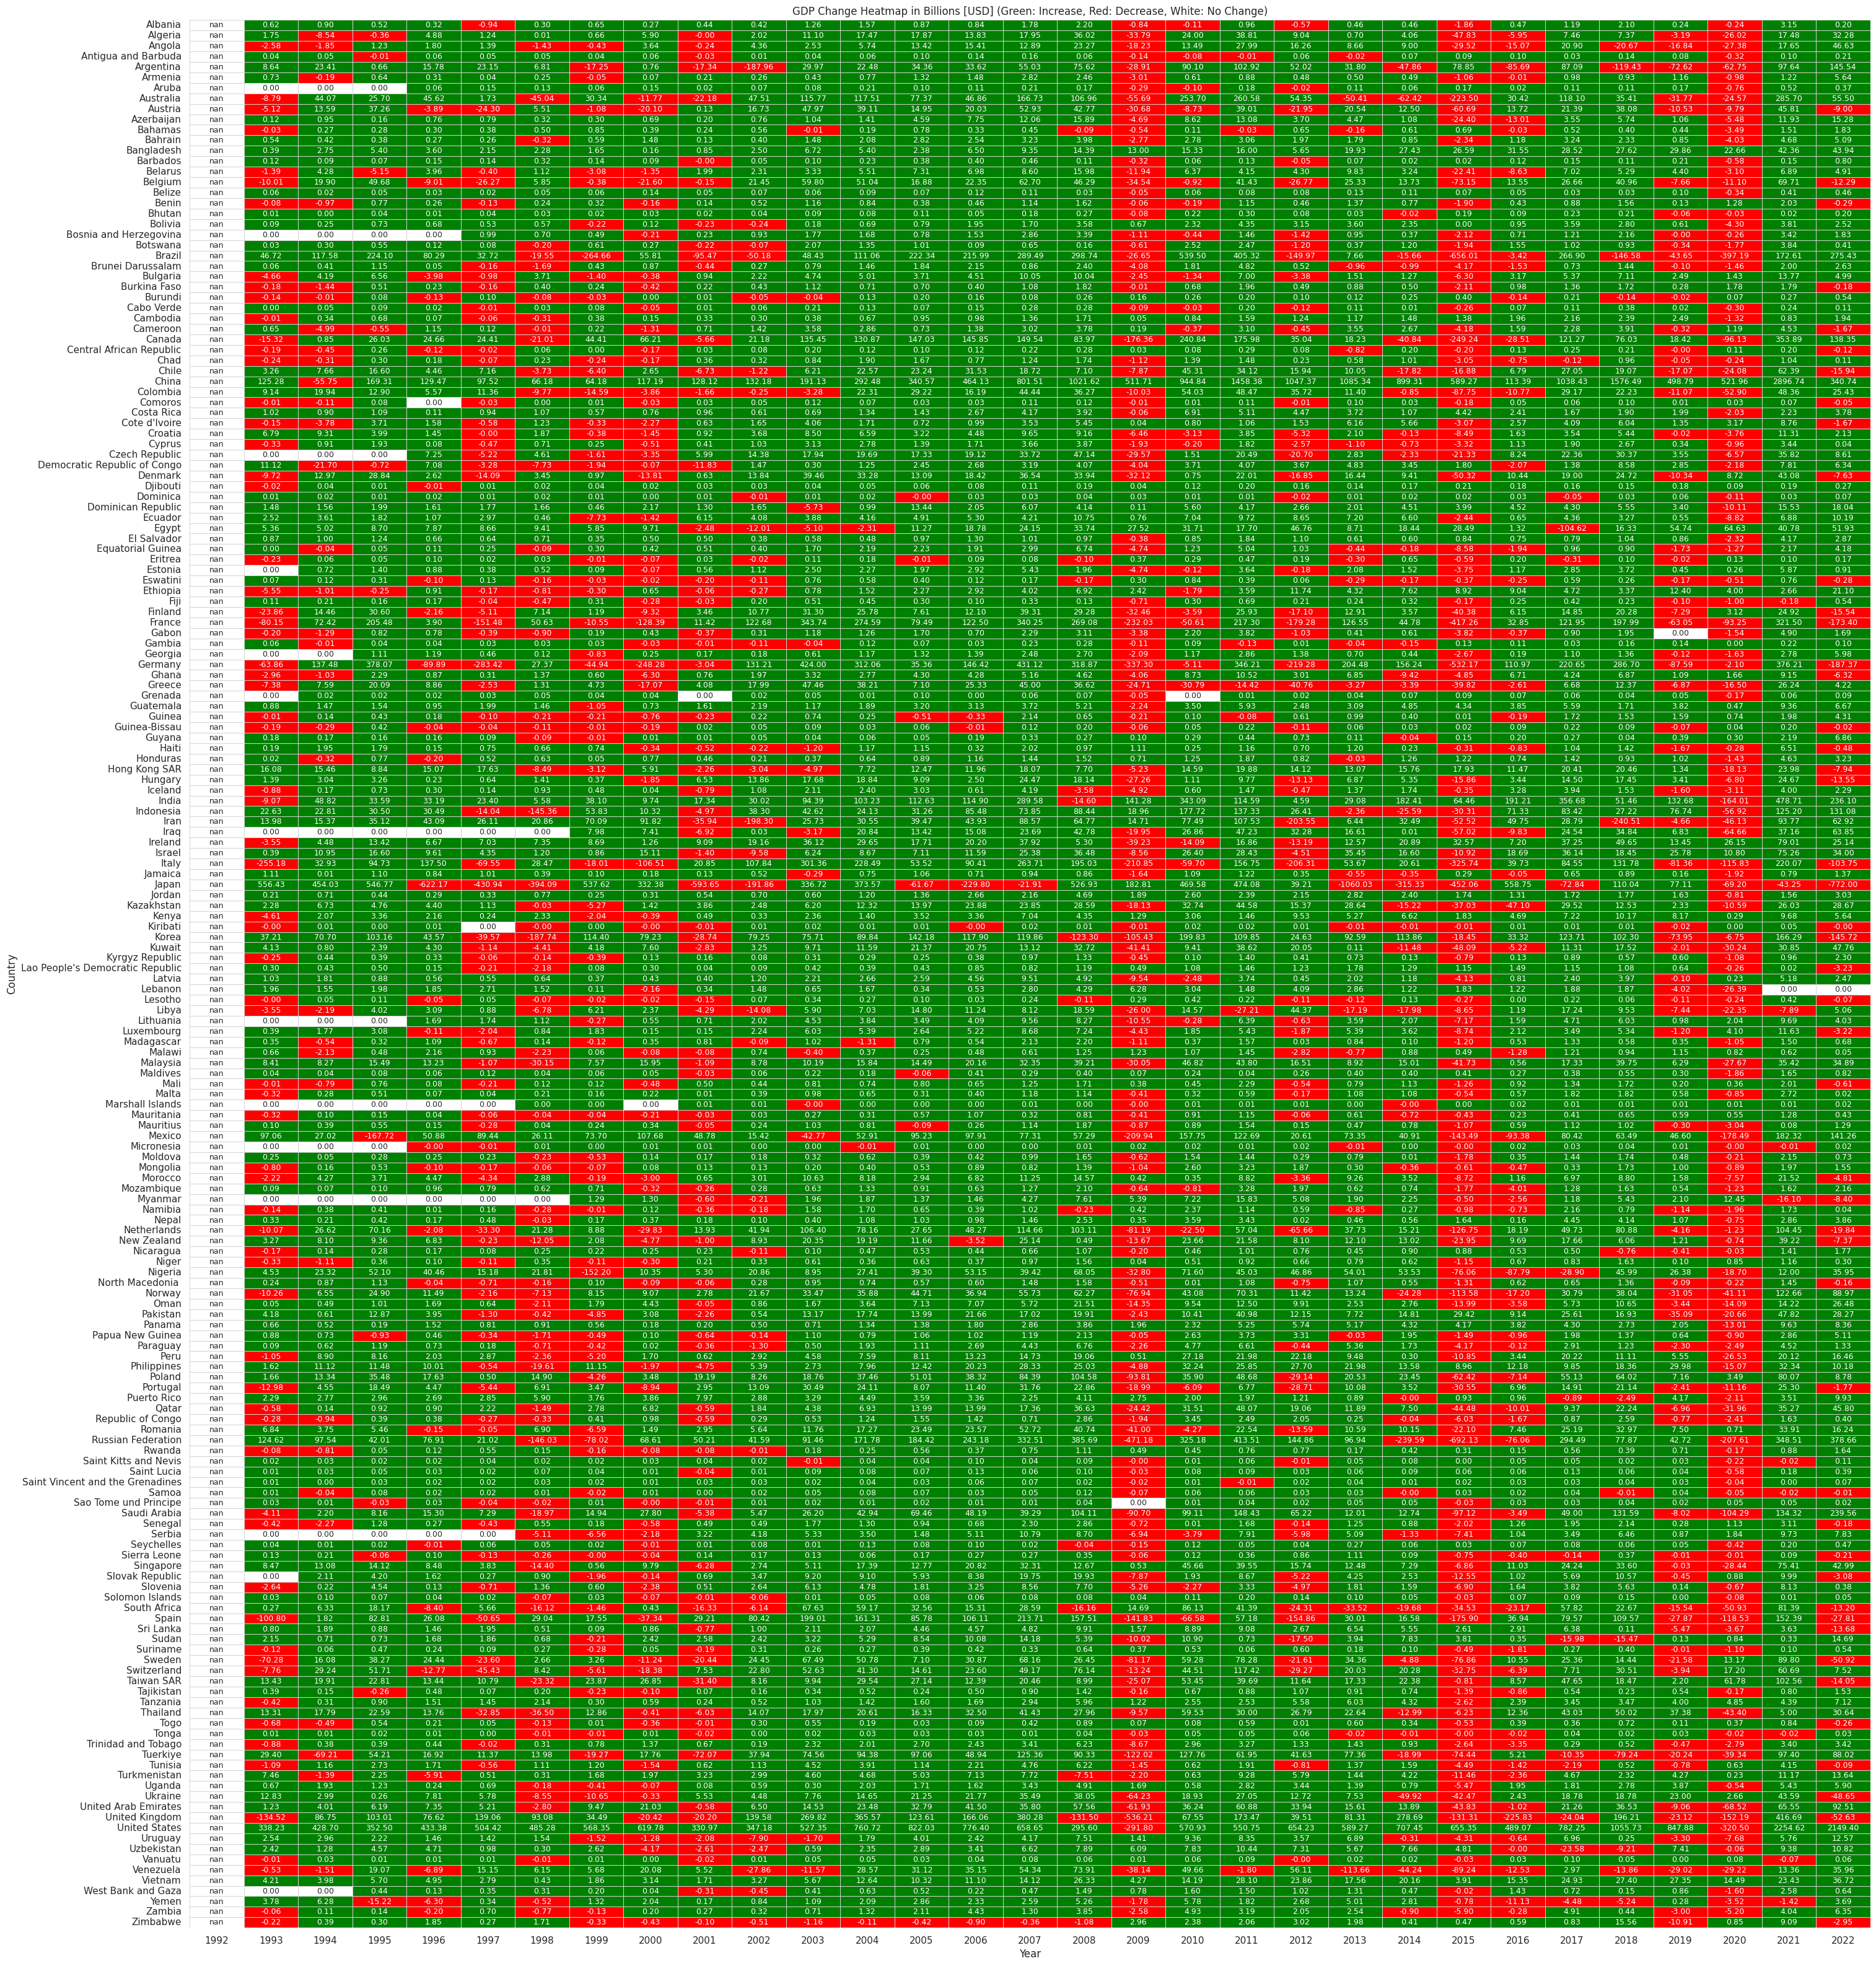

In [88]:

## Create a heatmap of the change in GDP from one year to the next for each country
dfh = gdp
# create a new column for the change in GDP from one year to the next
dfh['gdp_change'] = dfh.groupby('Country')['GDP'].diff()
dfh['gdp_change_category'] = np.where(dfh['gdp_change'] > 0, 'Increase', np.where(dfh['gdp_change'] < 0, 'Decrease', 'No Change'))

# create a mapper to map the gdp_change_category column to numerical values
mapper = {'Increase': 1, 'No Change': 0, 'Decrease': -1}

# Map the gdp_change_category column to numerical values
dfh['gdp_change_category'] = dfh['gdp_change_category'].map(mapper)

# Pivot the DataFrame to have years as columns and countries as index
df_pivot = dfh.pivot(index='Country', columns='year', values='gdp_change_category')

# Create a colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'white', 'green'])


## Calculate the absolute change in gdp from one year to the next as annotation for the heatmap
# Pivot the data to have each country's GDP as a separate column
pivot_data_labels = gdp.pivot(index='Country', columns='year', values='GDP')
# Calculate the change in GDP for each country from one year to the next
gdp_change_label = pivot_data_labels.diff(axis=1)


# Plot the heatmap
plt.figure(figsize=(35, 40))
sns.heatmap(df_pivot, annot=gdp_change_label, annot_kws={"fontsize":9}, cmap=cmap, cbar=False, linewidths=0.5, linecolor='lightgrey', fmt=".2f")
plt.xlabel('Year')
plt.ylabel('Country')
plt.title('GDP Change Heatmap in Billions [USD] (Green: Increase, Red: Decrease, White: No Change)')

plt.show()

In [89]:
%%capture
import bar_chart_race as bcr

# Assuming you have already loaded the data into a DataFrame named 'data'
# Let's say the columns are: 'Country', 'Year', 'GDP'

# Pivot the data to have each country's GDP as a separate column
pivot_data_race = gdp.pivot(index='Country', columns='year', values='GDP')
pivot_data_race.columns = pd.to_datetime(pivot_data_race.columns, format='%Y')

# Transpose the DataFrame to have years as columns and countries as rows
pivot_data_race = pivot_data_race.T


# Create the bar chart race animation
bcr.bar_chart_race(
    df=pivot_data_race,
    filename='highest_gdp_comparison.gif',
    orientation='h',       # Horizontal bars
    sort='desc',           # Sort bars in descending order at each frame
    n_bars=20,             # Number of bars (countries) to include in each frame
    steps_per_period=10,   # Number of steps (frames) per year
    period_length=500,     # Length of each period (milliseconds)
    title='Top 20 Countries with Highest GDPs in Billions (USD) with median',
    bar_label_size=7,      # Font size of bar labels
    tick_label_size=7,     # Font size of tick labels
    period_fmt='%Y',       # Show only the year for periodic steps
    shared_fontdict={'family': 'Helvetica', 'color': '.1'},  # Font settings
    filter_column_colors=True,  # Apply the color from the final frame to all frames
    perpendicular_bar_func='median',  # Set the median as the reference line
)

![SegmentLocal](highest_gdp_comparison.gif "segment")

#### b)
Pick a year with as little missing values as possible. <br>
For this year, create an interactive map with `folium` that tells you the GDP in the country in the given year. <br>
*Hint: Be cautious with country names.*

In [90]:
gdp_05 = gdp[gdp['year']==2005]

In [91]:
gdp_05.shape

(182, 5)

In [92]:
from geopy.geocoders import Nominatim

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# Create a world map
world_map= folium.Map(location=[10, -20], zoom_start=2.3)

# Loop over each country and its GDP
for idx, row in gdp_05.iterrows():
    # Get the location of the country
    location = geolocator.geocode(row['Country'])

    # If the location is found
    if location is not None:
        # Add a marker to the map
        folium.Marker(
            location=[location.latitude, location.longitude], 
            popup=f"Country: {row['Country']}, GDP: {row['GDP']}",
        ).add_to(world_map)

# Show the map
world_map


# Problem 3 - Supervised Machine Learning
#### a)
First, try to predict the GDP in a given year and in a given country using the data from the past years. <br>
Report the performance (measured in mean squared error) for different numbers of lags. 

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [94]:
gdp = gdp.drop(['gdp_change', 'gdp_change_category'], axis=1)

In [95]:
def train_model(df, country, model, lags):
    df_country = df[df['Country']==country].drop('Country', axis=1)
    df_country = df_country.sort_values(by='year').drop('year', axis=1)
    for lag in range(1, lags+1):
        df_country[f'GDP_lag_{lag}'] = df_country['GDP'].shift(lag)
    
    df_country = df_country.dropna()
    X_train, X_test, y_train, y_test = train_test_split(df_country.drop('GDP', axis=1),df_country['GDP'], test_size=.2,  shuffle=False)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test))
    return mse

In [96]:
linear = LinearRegression()
boost = AdaBoostRegressor(n_estimators=100, random_state=123)
forest = RandomForestRegressor(n_estimators = 50, random_state=123)
models = [linear, boost, forest]

In [97]:
results = []
for country in gdp['Country'].unique():
    for lags in range (3, 6):
        row = {'Country': country, 'lag': lags}
        for model in models:
            mse = train_model(gdp, country, model, lags)
            results.append({'Country': country, 'lag': lags, 'model': type(model).__name__, 'mse': mse})

result_df = pd.DataFrame(results)

result_df.head()

,Country,lag,model,mse
0,Albania,3,LinearRegression,2.199529
1,Albania,3,AdaBoostRegressor,19.767143
2,Albania,3,RandomForestRegressor,15.985890
3,Albania,4,LinearRegression,2.567171
4,Albania,4,AdaBoostRegressor,19.119210


In [98]:
best_models_per_country = result_df.loc[result_df.groupby('Country')['mse'].idxmin()]
best_models_per_country

,Country,lag,model,mse
0,Albania,3,LinearRegression,2.199529e+00
11,Algeria,3,RandomForestRegressor,3.207194e+02
18,Angola,3,LinearRegression,7.375986e+02
27,Antigua and Barbuda,3,LinearRegression,3.754202e-02
36,Argentina,3,LinearRegression,1.008623e+04
51,Armenia,5,LinearRegression,5.245387e+00
60,Aruba,5,LinearRegression,1.540163e-01
63,Australia,3,LinearRegression,1.461283e+04
72,Austria,3,LinearRegression,5.526519e+02
88,Azerbaijan,5,AdaBoostRegressor,1.039363e+01


#### b)
Now, see if you can improve the prediction with additional data. <br>
In this task, you are supposed to be creative and use your intuition. What could be important predictors? Think of, for example:
- Country characteristics such as population, unemployment rates etc. <br> *Hint: You can search for official statistics, e.g., from OECD.*
- Major historical events such as wars, natural disasters etc. <br> *Hint: You can make dummy variables if such an event happened for given country and year.*
- Geographical information such as continent.

*Note: It is well possible that you can't find data on very small countries. If you don't find data for some countries, you can drop them.*

In [99]:
current_year = datetime.datetime.now().year

In [100]:
#Little test with wbgapi, to build directly a dataframe
# https://nbviewer.org/github/tgherzog/wbgapi/blob/master/examples/wbgapi-cookbook.ipynb
#wba.data.DataFrame(['SP.POP.TOTL', 'NY.GDP.PCAP.CD'],
#                  time=range(2010,2015), skipBlanks=True, columns='series')

In [101]:
#Get countries from World Bank API and drop unnecessary data
countries = wb.get_countries()
countries = countries[countries['incomeLevel'] != 'Aggregates'].rename(columns={'name': 'countryName'})
countries.drop(['iso2Code', 'adminregion', 'capitalCity', 'lendingType', 'longitude', 'latitude'], axis=1, inplace=True)
countries.reset_index(level=0, inplace=True)
countries.head()

,id,countryName,region,incomeLevel
0,ABW,Aruba,Latin America & Caribbean,High income
1,AFG,Afghanistan,South Asia,Low income
2,AGO,Angola,Sub-Saharan Africa,Lower middle income
3,ALB,Albania,Europe & Central Asia,Upper middle income
4,AND,Andorra,Europe & Central Asia,High income


In [349]:
data_series_dict = {
    #'Battle-related deaths (number of people)' : 'VC.BTL.DETH',
    #'Droughts, floods, extreme temperatures' : 'EN.CLC.MDAT.ZS',
    'Populalation':'SP.POP.TOTL',
    'Unemployment, total (% of total labor force) (national estimate)' : 'SL.UEM.TOTL.NE.ZS',
    #'Real interest rate (%)':'FR.INR.RINR',
    'Inflation, consumer prices (annual %)':'FP.CPI.TOTL.ZG',
    'Imports of goods and services (in $)':'NE.IMP.GNFS.CD',
    'Export of goods and services (in $)':'NE.EXP.GNFS.CD'

	
}

df = pd.DataFrame()

for var_name, series_name in data_series_dict.items():
    #Get series with the dict
    data_series = wb.get_series(series_name, date='1992:'+str(current_year), id_or_value='id')

    # Reset index, drop 'Series' column, and rename the series column
    data_series_df = data_series.reset_index().drop(columns=['Series'])
    data_series_df.rename(columns={series_name: var_name}, inplace=True)

    # If result DataFrame is empty, copy the current data
    if df.empty:
        df = data_series_df.copy()
    else:
        # Otherwise merge current data with existing DataFrame
        df = pd.merge(df, data_series_df, on=['Country', 'Year'], how='outer')
df.head()

,Country,Year,Populalation,"Unemployment, total (% of total labor force) (national estimate)","Inflation, consumer prices (annual %)",Imports of goods and services (in $),Export of goods and services (in $)
0,AFE,1992,326933522.0,NaN,16.167612,5.048891e+10,5.202931e+10
1,AFE,1993,335625136.0,NaN,13.135661,5.057682e+10,5.461593e+10
2,AFE,1994,344418362.0,NaN,14.852815,5.795273e+10,5.793305e+10
3,AFE,1995,353466601.0,NaN,12.288591,7.007641e+10,6.686237e+10
4,AFE,1996,362985802.0,NaN,9.706586,7.139533e+10,6.967206e+10


In [350]:
# Merge country information into the df
df = pd.merge(df, countries, left_on='Country', right_on='id')
df.drop(['id'], axis=1, inplace=True)
#df.set_index(['Country', 'Year'], inplace=True)
df.head()

,Country,Year,Populalation,"Unemployment, total (% of total labor force) (national estimate)","Inflation, consumer prices (annual %)",Imports of goods and services (in $),Export of goods and services (in $),countryName,region,incomeLevel
0,AFG,1992,12057433.0,NaN,NaN,NaN,NaN,Afghanistan,South Asia,Low income
1,AFG,1993,14003760.0,NaN,NaN,NaN,NaN,Afghanistan,South Asia,Low income
2,AFG,1994,15455555.0,NaN,NaN,NaN,NaN,Afghanistan,South Asia,Low income
3,AFG,1995,16418912.0,NaN,NaN,NaN,NaN,Afghanistan,South Asia,Low income
4,AFG,1996,17106595.0,NaN,NaN,NaN,NaN,Afghanistan,South Asia,Low income


In [351]:
list(df)

['Country',
 'Year',
 'Populalation',
 'Unemployment, total (% of total labor force) (national estimate)',
 'Inflation, consumer prices (annual %)',
 'Imports of goods and services (in $)',
 'Export of goods and services (in $)',
 'countryName',
 'region',
 'incomeLevel']

In [352]:
#df['Battle-related deaths (number of people)'] = df['Battle-related deaths (number of people)'].notna().astype(int)

In [353]:
#df['Droughts, floods, extreme temperatures'] = df['Droughts, floods, extreme temperatures'].notna().astype(int)

In [354]:
#df['Real interest rate (%)'] = df.groupby('Country',group_keys=False)['Real interest rate (%)'].apply(lambda group: group.fillna(method='ffill'))
df['Inflation, consumer prices (annual %)'] = df.groupby('Country',group_keys=False)['Inflation, consumer prices (annual %)'].apply(lambda group: group.fillna(method='ffill'))
df['Unemployment, total (% of total labor force) (national estimate)'] = df.groupby('Country',group_keys=False)['Unemployment, total (% of total labor force) (national estimate)'].apply(lambda group: group.fillna(method='ffill'))

In [355]:
missing_values_per_country = df.isnull().sum(axis=1).groupby(df['countryName']).sum()
missing_values_per_country.sort_values(ascending=False, inplace=True)
missing_values_per_country

countryName
British Virgin Islands            124
Korea, Dem. People's Rep.         124
St. Martin (French part)          124
Gibraltar                         124
Andorra                           124
Channel Islands                   124
Turks and Caicos Islands          102
Monaco                            101
Somalia                           100
Liechtenstein                      93
Isle of Man                        93
Afghanistan                        91
Tuvalu                             91
Sint Maarten (Dutch part)          91
Liberia                            90
Virgin Islands (U.S.)              86
Eritrea                            84
Djibouti                           80
South Sudan                        79
French Polynesia                   77
Curacao                            76
Malawi                             75
Palau                              75
Sao Tome and Principe              75
Bermuda                            75
Cayman Islands                     73


In [356]:
#df['Real interest rate (%)'] = df.groupby('Country',group_keys=False)['Real interest rate (%)'].apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
df['Inflation, consumer prices (annual %)'] = df.groupby('Country',group_keys=False)['Inflation, consumer prices (annual %)'].apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
df['Unemployment, total (% of total labor force) (national estimate)'] = df.groupby('Country',group_keys=False)['Unemployment, total (% of total labor force) (national estimate)'].apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))

In [357]:
df = df[~df['Country'].isin(missing_values_per_country[missing_values_per_country > 8].index)]
df.shape

(6727, 10)

In [358]:
missing_values = df.isnull().sum()
missing_values.sort_values(ascending=False, inplace=True)
missing_values

Imports of goods and services (in $)                                1318
Export of goods and services (in $)                                 1318
Inflation, consumer prices (annual %)                                775
Unemployment, total (% of total labor force) (national estimate)     341
Country                                                                0
Year                                                                   0
Populalation                                                           0
countryName                                                            0
region                                                                 0
incomeLevel                                                            0
dtype: int64

In [359]:
#df = df.drop(missing_values[missing_values>500].index, axis=1)
#df = df.groupby('Country').filter(lambda x: ~x.isnull().all().any())
df.head()

,Country,Year,Populalation,"Unemployment, total (% of total labor force) (national estimate)","Inflation, consumer prices (annual %)",Imports of goods and services (in $),Export of goods and services (in $),countryName,region,incomeLevel
0,AFG,1992,12057433.0,2.49,12.686269,NaN,NaN,Afghanistan,South Asia,Low income
1,AFG,1993,14003760.0,2.49,12.686269,NaN,NaN,Afghanistan,South Asia,Low income
2,AFG,1994,15455555.0,2.49,12.686269,NaN,NaN,Afghanistan,South Asia,Low income
3,AFG,1995,16418912.0,2.49,12.686269,NaN,NaN,Afghanistan,South Asia,Low income
4,AFG,1996,17106595.0,2.49,12.686269,NaN,NaN,Afghanistan,South Asia,Low income


In [360]:
df.shape

(6727, 10)

In [361]:
for column in data_series_dict.keys():
    print(column)
    if column in df.columns:
        print(column + ' inter')  # We don't want to interpolate the 'Country' column
        df[column] = df.groupby('Country', group_keys=False)[column].apply(lambda group: group.interpolate(limit_direction='both'))

Populalation
Populalation inter
Unemployment, total (% of total labor force) (national estimate)
Unemployment, total (% of total labor force) (national estimate) inter
Inflation, consumer prices (annual %)
Inflation, consumer prices (annual %) inter
Imports of goods and services (in $)
Imports of goods and services (in $) inter


Export of goods and services (in $)
Export of goods and services (in $) inter


In [362]:
df = df.groupby('Country').filter(lambda x: ~x.isnull().all().any())

In [363]:
missing_values = df.isnull().sum()
missing_values.sort_values(ascending=False, inplace=True)
missing_values

Country                                                             0
Year                                                                0
Populalation                                                        0
Unemployment, total (% of total labor force) (national estimate)    0
Inflation, consumer prices (annual %)                               0
Imports of goods and services (in $)                                0
Export of goods and services (in $)                                 0
countryName                                                         0
region                                                              0
incomeLevel                                                         0
dtype: int64

In [364]:
# Filter rows containing at least one missing value
missing_values_sample = df[df.isnull().any(axis=1)]

# Display a sample of rows with missing values
missing_values_sample


,Country,Year,Populalation,"Unemployment, total (% of total labor force) (national estimate)","Inflation, consumer prices (annual %)",Imports of goods and services (in $),Export of goods and services (in $),countryName,region,incomeLevel


In [365]:
gdp['Country'] = gdp['Country'].replace('Tuerkiye', 'Turkey')
converter = coco.CountryConverter()
gdp['countryKey'] = gdp['Country'].apply(lambda x: converter.convert(names=x, to='ISO3'))
gdp['Country'] = gdp['Country'].replace('Turkey', 'Tuerkiye')
gdp.sample(10)

,Country,year,GDP,countryKey
2269,Finland,1998,134.212,FIN
1417,Democratic Republic of Congo,2014,38.355,COD
4316,Niger,1999,2.532,NER
770,Bolivia,2018,40.581,BOL
2291,Finland,2020,271.668,FIN
4243,Netherlands,2019,910.295,NLD
2661,Guyana,2018,4.788,GUY
4627,Panama,2000,12.502,PAN
2565,Guatemala,2015,62.180,GTM
1314,China,2004,1949.446,CHN


In [366]:
not_found = gdp[gdp['countryKey'] == 'not found']
not_found

,Country,year,GDP,countryKey


In [367]:
len(gdp['Country'].unique())

182

In [368]:
df.rename(columns={'Country': 'countryKey'}, inplace=True)
df['Year'] = df['Year'].astype(int)
gdp['year'] = gdp['year'].astype(int)
merged = pd.merge(df, gdp, how='inner', left_on=['countryKey', 'Year'], right_on=['countryKey', 'year'])
merged.head(20)

,countryKey,Year,Populalation,"Unemployment, total (% of total labor force) (national estimate)","Inflation, consumer prices (annual %)",Imports of goods and services (in $),Export of goods and services (in $),countryName,region,incomeLevel,Country,year,GDP
0,ALB,1992,3247039.0,26.50,226.005421,6.279524e+08,8.151921e+07,Albania,Europe & Central Asia,Upper middle income,Albania,1992,0.843
1,ALB,1993,3227287.0,22.30,85.004751,7.649967e+08,1.893995e+08,Albania,Europe & Central Asia,Upper middle income,Albania,1993,1.461
2,ALB,1994,3207536.0,18.40,22.565053,7.734261e+08,2.254074e+08,Albania,Europe & Central Asia,Upper middle income,Albania,1994,2.361
3,ALB,1995,3187784.0,12.90,7.793219,8.367443e+08,3.024653e+08,Albania,Europe & Central Asia,Upper middle income,Albania,1995,2.882
4,ALB,1996,3168033.0,12.30,12.725478,1.064684e+09,3.718089e+08,Albania,Europe & Central Asia,Upper middle income,Albania,1996,3.200
5,ALB,1997,3148281.0,14.90,33.180274,7.956390e+08,2.303035e+08,Albania,Europe & Central Asia,Upper middle income,Albania,1997,2.259
6,ALB,1998,3128530.0,17.70,20.642859,9.336146e+08,2.919500e+08,Albania,Europe & Central Asia,Upper middle income,Albania,1998,2.560
7,ALB,1999,3108778.0,18.40,0.389438,1.097558e+09,5.409779e+08,Albania,Europe & Central Asia,Upper middle income,Albania,1999,3.209
8,ALB,2000,3089027.0,16.80,0.050018,1.508344e+09,7.000834e+08,Albania,Europe & Central Asia,Upper middle income,Albania,2000,3.483
9,ALB,2001,3060173.0,16.40,3.107588,1.771127e+09,8.367179e+08,Albania,Europe & Central Asia,Upper middle income,Albania,2001,3.928


In [369]:
len(merged['Country'].unique())

167

In [370]:
merged.drop(columns=['countryKey', 'countryName', 'Year',  'region', 'incomeLevel'], axis=1, inplace=True)
merged.rename(columns={'Year': 'year'}, inplace=True)




In [371]:
merged.head()

,Populalation,"Unemployment, total (% of total labor force) (national estimate)","Inflation, consumer prices (annual %)",Imports of goods and services (in $),Export of goods and services (in $),Country,year,GDP
0,3247039.0,26.5,226.005421,6.279524e+08,8.151921e+07,Albania,1992,0.843
1,3227287.0,22.3,85.004751,7.649967e+08,1.893995e+08,Albania,1993,1.461
2,3207536.0,18.4,22.565053,7.734261e+08,2.254074e+08,Albania,1994,2.361
3,3187784.0,12.9,7.793219,8.367443e+08,3.024653e+08,Albania,1995,2.882
4,3168033.0,12.3,12.725478,1.064684e+09,3.718089e+08,Albania,1996,3.200


In [372]:
merged.isnull().sum(axis=1).sum()

0

In [373]:
results = []
for country in merged['Country'].unique():
    for lags in range (3, 6):
        row = {'Country': country, 'lag': lags}
        for model in models:
            mse = train_model(merged, country, model, lags)
            results.append({'Country': country, 'lag': lags, 'model': type(model).__name__, 'mse': mse})

result_df_new = pd.DataFrame(results)

result_df_new.head()

,Country,lag,model,mse
0,Albania,3,LinearRegression,1.759006
1,Albania,3,AdaBoostRegressor,14.166357
2,Albania,3,RandomForestRegressor,14.100331
3,Albania,4,LinearRegression,1.774260
4,Albania,4,AdaBoostRegressor,14.025104


In [374]:
best_models_per_country_new = result_df_new.loc[result_df_new.groupby('Country')['mse'].idxmin()]
best_models_per_country_new

,Country,lag,model,mse
0,Albania,3,LinearRegression,1.759006e+00
9,Algeria,3,LinearRegression,1.600159e+02
26,Angola,5,RandomForestRegressor,5.714944e+02
33,Antigua and Barbuda,5,LinearRegression,4.951438e-02
36,Armenia,3,LinearRegression,2.093975e+00
45,Aruba,3,LinearRegression,5.443419e-02
62,Australia,5,RandomForestRegressor,1.520214e+04
66,Austria,4,LinearRegression,1.328965e+02
76,Azerbaijan,4,AdaBoostRegressor,9.434085e+00
87,Bahamas,5,LinearRegression,4.120514e-01


In [375]:
best_models_per_country[best_models_per_country['Country']=='China']

,Country,lag,model,mse
306,China,3,LinearRegression,2.472157e+06


In [376]:
best_models_per_country_new[best_models_per_country_new['Country']=='China']

,Country,lag,model,mse
288,China,3,LinearRegression,926148.358793


In [377]:
# Function to compare the mse from each dataframe
def compare_mse(row):
    if row['mse_old'] < row['mse_new']:
        return 0
    elif row['mse_new'] < row['mse_old']:
        return 1
    else:
        return -1
combined_df = best_models_per_country.merge(best_models_per_country_new, on='Country', suffixes=('_old', '_new'))

# Apply comparison function and create new column
combined_df['smaller_mse'] = combined_df.apply(compare_mse, axis=1)

# Create resulting dataframe
comparison_result = combined_df[['Country', 'smaller_mse', 'mse_old', 'mse_new']]


In [378]:
comparison_result

,Country,smaller_mse,mse_old,mse_new
0,Albania,1,2.199529e+00,1.759006e+00
1,Algeria,1,3.207194e+02,1.600159e+02
2,Angola,1,7.375986e+02,5.714944e+02
3,Antigua and Barbuda,0,3.754202e-02,4.951438e-02
4,Armenia,1,5.245387e+00,2.093975e+00
5,Aruba,1,1.540163e-01,5.443419e-02
6,Australia,0,1.461283e+04,1.520214e+04
7,Austria,1,5.526519e+02,1.328965e+02
8,Azerbaijan,1,1.039363e+01,9.434085e+00
9,Bahamas,1,1.531486e+00,4.120514e-01


In [379]:
comparison_result['smaller_mse'].sum()

96

# Problem 4 - Unsupervised Machine Learning 
Use GDP and the information from Problem 3b) to cluster countries. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified?

In [380]:
temp_backup_merged = merged.copy()

In [381]:
merged = temp_backup_merged.copy()
merged.head()

,Populalation,"Unemployment, total (% of total labor force) (national estimate)","Inflation, consumer prices (annual %)",Imports of goods and services (in $),Export of goods and services (in $),Country,year,GDP
0,3247039.0,26.5,226.005421,6.279524e+08,8.151921e+07,Albania,1992,0.843
1,3227287.0,22.3,85.004751,7.649967e+08,1.893995e+08,Albania,1993,1.461
2,3207536.0,18.4,22.565053,7.734261e+08,2.254074e+08,Albania,1994,2.361
3,3187784.0,12.9,7.793219,8.367443e+08,3.024653e+08,Albania,1995,2.882
4,3168033.0,12.3,12.725478,1.064684e+09,3.718089e+08,Albania,1996,3.200


**Experiment 1**

In [382]:
import pandas as pd

# Assuming your original dataframe is named 'df'
df = merged

# Set the multi-index with 'Country' and 'year'
df_pivoted = df.set_index(['Country', 'year'])

# Swap 'year' as a key level above the current columns
df_pivoted = df_pivoted.unstack(level='year')

# Swap the column names so that 'year' is on top
df_pivoted.columns = df_pivoted.columns.swaplevel(0, 1)

# Sort the columns in ascending order based on the 'year'
df_pivoted = df_pivoted.sort_index(axis=1)

# Display the DataFrame with the updated structure
df_pivoted.head()

year                                               1992           
                    Export of goods and services (in $)     GDP   
Country                                                           
Albania                                    8.151921e+07   0.843  \
Algeria                                    1.215420e+10  49.217   
Angola                                     8.187953e+09   9.395   
Antigua and Barbuda                        7.664444e+08   0.499   
Armenia                                    5.068527e+08   0.108   

year                                                       
                    Imports of goods and services (in $)   
Country                                                    
Albania                                     6.279524e+08  \
Algeria                                     1.145810e+10   
Angola                                      5.738980e+09   
Antigua and Barbuda                         4.939259e+08   
Armenia                                     7.796881e+08   

year                                                                     
                    Inflation, consumer prices (annual %) Populalation   
Country                                                                  
Albania                                        226.005421    3247039.0  \
Algeria                                         31.669662   26748303.0   
Angola                                         299.509804   12632507.0   
Antigua and Barbuda                              1.121288      64659.0   
Armenia                                       3373.759443    3574555.0   

year                                                                                   
                    Unemployment, total (% of total labor force) (national estimate)   
Country                                                                                
Albania                                                          26.50                \
Algeria                                                          24.38                 
Angola                                                           23.64                 
Antigua and Barbuda                                               8.42                 
Armenia                                                           1.80                 

year                                               1993           
                    Export of goods and services (in $)     GDP   
Country                                                           
Albania                                    1.893995e+08   1.461  \
Algeria                                    1.088008e+10  50.963   
Angola                                     8.187953e+09   6.819   
Antigua and Barbuda                        7.664444e+08   0.535   
Armenia                                    5.672476e+08   0.835   

year                                                       
                    Imports of goods and services (in $)   
Country                                                    
Albania                                     7.649967e+08  \
Algeria                                     1.155688e+10   
Angola                                      5.738980e+09   
Antigua and Barbuda                         4.939259e+08   
Armenia                                     7.298476e+08   

year                                                       ...   
                    Inflation, consumer prices (annual %)  ...   
Country                                                    ...   
Albania                                         85.004751  ...  \
Algeria                                         20.540326  ...   
Angola                                        1378.527607  ...   
Antigua and Barbuda                              1.121288  ...   
Armenia                                       3373.759443  ...   

year                                                2021   
                    Imports of goods and services (in $)   
Country          

In [383]:
%%capture
# Standardize the data before PCA and clustering
#scaler = StandardScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(df_pivoted), columns=df_pivoted.columns)

# Determine the optimal number of clusters using the elbow method
inertia_values = []
max_clusters = 10
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pivoted)
    inertia_values.append(kmeans.inertia_)

NameError: name 'KMeans' is not defined

In [ ]:
# Plot the elbow graph to choose the optimal number of clusters (e.g., 3 or 4)
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [ ]:
# Choose the optimal number of clusters based on the elbow graph
n_clusters = 3 # You can change this based on the elbow graph
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_pivoted['Cluster'] = kmeans.fit_predict(df_scaled)

In [ ]:
df_pivoted.head(20)

In [ ]:
# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(df_pivoted.values)
df_pivoted["PC1"] = pca_result[:,0]
df_pivoted["PC2"] = pca_result[:,1]
df_pivoted["PC3"] = pca_result[:,1]

# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 5))
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()
#plt.plot(range(1, len(explained_variance_ratio_cumsum)+1), explained_variance_ratio_cumsum, marker='o')
plt.plot(range(1, len(explained_variance_ratio_cumsum)+1), explained_variance_ratio_cumsum, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.xlim(1, 10)
plt.show()

In [ ]:
df_pivoted.head(20)

In [ ]:
# Create an interactive scatter plot using plotly
fig = px.scatter_3d(df_pivoted, x='PC1', y='PC2',z='PC3', color='Cluster')
fig.update_layout(showlegend=True)

# Show the interactive plot
fig.show()